# Deskewing pages
This notebook was designed to introduce one method for automatically deskewing page images in preparation for OCR. For our purposes in this iteration of the class, the details of the process are less important than seeing an example of the ways that images can be computationally changed after initial photography: when you're looking at a digital surrogate, you're seeing an image that has likely been through several processes that attempt to optimize it for the task at hand without a human having to check it at each step of the way.

The code in this notebook is drawn from a blog post by Leo Ertuna at [Becoming Human](https://becominghuman.ai/how-to-automatically-deskew-straighten-a-text-image-using-opencv-a0c30aed83df), but with an adjustment that some experimenting suggests seems to work better for early print.

## 1 - Connect to Google Drive, copy files, and install packages

In [ ]:
#Code cell #1
#Get access to Google Drive
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
#Code cell #2
%cp -r /gdrive/MyDrive/rbs_digital_approaches_2023/output/cropped.zip /content/cropped.zip
%cd /content/
!unzip cropped.zip

In [ ]:
#Code cell #3
#Install IPyWidgets to provide widgets for experimenting with some variables later
import ipywidgets as widgets
from ipywidgets import interact

#Import necessary Python packages for use in our code.
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

## 2 - Opening the image

In [ ]:
#@title Select an image
 #@markdown **Run this cell** to create a select
 #@markdown list widget that allows us to
 #@markdown choose an image to process. With
 #@markdown an image selected (a default is
 #@markdown provided), you can continue
 #@markdown working through the code below.
 #@markdown FYI: 1730f_p0iv, 1730g_p21, and
 #@markdown 1730j_p21 are the best examples
 #@markdown of skewed pages in this set.

 #@markdown You only need to run this cell once (re-running it will just set things back to the default value). But you can change the image you're working with using the select list in order to see how these processes work given different starting images.

import os
import glob
file_list = sorted([os.path.basename(file) for file in glob.glob('/content/cropped/*.tif')])
image_select = widgets.Dropdown(
    description='Choose image',\
    options = file_list,\
    value = '1730f_p0iv-cropped.tif',
    style={'description_width': 'initial'})
display(image_select)

In [ ]:
#Code cell #5
#Identify the skewed image and have OpenCV read it. (This can take a little
#while, so give it time to complete.)

source_directory = '/content/cropped/'
skewed_image = source_directory + image_select.value
im = cv2.imread(skewed_image, cv2.IMREAD_COLOR)
#Let's see what the image looks like: an excellent image, but a little skewed.
cv2_imshow(im)

## 3 - Deskewing the image

In [ ]:
#Code cell #6
#Make a copy of the image
new_image = im.copy()
#Convert to grayscale
gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
#Apply a Gaussian blur to reduce the effect of any noise in the image
blur = cv2.GaussianBlur(gray, (9, 9), 0)
#Convert the image to inverted black and white (i.e., white text on a
#black background). Note that Ertuna's script uses Otsu's method for
#thresholding to black and white.
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
cv2_imshow(thresh)

### 3.a - Set kernel size for dilation

In [ ]:
#@title Set kernel size {display-mode: "form"}

#@markdown **Run this cell** to create a set of
#@markdown slider widgets for changing the values of the
#@markdown "kernel" used to dilate the white pixels in the
#@markdown image. You can change the height and width of the
#@markdown kernel (i.e., the amount of vertical and horizontal
#@markdown dilation to be applied) as well as the number of
#@markdown iterations (how many times the dilation operation
#@markdown will be applied.)

#@markdown You only need to run this cell once (re-running
#@markdown it will just re-set the values to their defaults).
#@markdown You can change the values of the sliders and
#@markdown then run Code cell 12 to see the different
#@markdown effects that different values have.
kernel_width = widgets.IntSlider(description = 'Kernel width', \
                                               min=1, max=25, step=1, value=25)
kernel_height = widgets.IntSlider(description='Kernel height', \
                                                 min=1, max=25, step=1, value=1)
num_iterations = widgets.IntSlider(description='Iterations', min=1, \
                      max=10, step=1, value=3)
display(kernel_width)
display(kernel_height)
display(num_iterations)

### 3.b - This is weird, but we've seen this before

In [ ]:
#Code cell #7
#The kernel variable defines a shape to use for dilating the pixels. If the kernel
#is wider than it is tall, the text will tend to run together while more or less
#maintaining the vertical dimensions of the text lines.
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_width.value, kernel_height.value))

dilate = cv2.dilate(thresh, kernel, iterations=num_iterations.value)
cv2_imshow(dilate)

In [ ]:
#Code cell #8
#Determine contours
contours, hierarchy = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#These next steps are not really part of the deskewing sequence. I've included
#them simply so we can see what's happening.
show_contours = cv2.cvtColor(dilate, cv2.COLOR_BayerGR2RGB)
show_contours = cv2.drawContours(show_contours, contours, -1, (115,255,105), 3)
cv2_imshow(show_contours)

### 3.c - Finding the rectangles that fit these contours
In the last notebook, we used `boundingRect` to find *straight* bounding rectangles around the text contours. Our problem is slightly different here, since we're interested in lines that *aren't* straight.

OpenCV's `minAreaRect` finds the *smallest possible* rectangle that will contain the contour, even if that that smallest possible rectangle is rotated relative to the square edges of the image.

This really seems like a case where a picture is worth a thousand words: the green rectangle is produced by `boundingRect` while the red one is produced by `minAreaRect`.



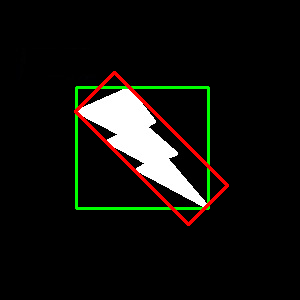

`minAreaRect` provides:

* the x, y coordinates of the center point of the rectangle;
* the width and height of the rectangle; and
* the *rotation angle* of the rectangle—which is what we're trying to correct for. (For more on how `minAreaRect` treats this angle, see [this post at *The AI Learner*](https://theailearner.com/tag/cv2-minarearect/). Note, though, that there appears to have been a change in the way OpenCV represents rotation angles that has left lots of people asking for help on Stack Overflow...)

In [ ]:
#@title Draw `minAreaRect` boxes {display-mode: "form"}

#@markdown **Run this cell** to make a function called `draw_min_area_rect`
#@markdown available for drawing boxes
#@markdown to show `minAreaRect` rectangles. This code isn't
#@markdown really part of the procedure, it's just so we can
#@markdown see what's happening. It's more confusing than it's
#@markdown worth our while to examine in this context, but you can
#@markdown look at it if you want to. You were warned.

#Code cell #9
def draw_min_area_rect(cv2minimumarearectangle, base_image) :
  draw_min_area_rect = base_image.copy()
  #If we have more than one recttangle...
  if isinstance(cv2minimumarearectangle, list) == True :
    print(len(cv2minimumarearectangle))
    for rect in cv2minimumarearectangle :
      #boxPoints gets the coordinates of the four corners of the rotated rectangle,
      #which is nice, because figuring them out ourselves would be sort of a drag,
      #given the way those rectangles are (of necessity) represented in OpenCV.
      min_area_box = cv2.boxPoints(rect)
      #Turn corner coordinates into integers
      min_area_box = np.int0(min_area_box)
      #Draw this rectangle one side at a time, beginning from the upper left
      #corner and working clockwise.
      draw_min_area_rect = cv2.line(draw_min_area_rect, (min_area_box[0][0], min_area_box[0][1]), \
                                    (min_area_box[1][0], min_area_box[1][1]), (0, 30, 255), 3)
      draw_min_area_rect = cv2.line(draw_min_area_rect, (min_area_box[1][0], min_area_box[1][1]), \
                                    (min_area_box[2][0], min_area_box[2][1]), (0, 30, 255), 3)
      draw_min_area_rect = cv2.line(draw_min_area_rect, (min_area_box[2][0], min_area_box[2][1]), \
                                    (min_area_box[3][0], min_area_box[3][1]), (0, 30, 255), 3)
      draw_min_area_rect = cv2.line(draw_min_area_rect, (min_area_box[3][0], min_area_box[3][1]), \
                                    (min_area_box[0][0], min_area_box[0][1]), (0, 30, 255), 3)
      #Print the angle of rotation in the center of the rectangle
      cv2.putText(draw_min_area_rect, str(rect[-1]),
                  (int(rect[0][0]) -100, int(rect[0][1])), cv2.FONT_HERSHEY_SIMPLEX,
                  1, (0, 30, 255, 255), 3)
  else :
    min_area_box = cv2.boxPoints(cv2minimumarearectangle)
    min_area_box = np.int0(min_area_box)
    #This gnarly code again... I should really refactor this into a function,
    #because I hate looking at it, and once is bad enough.
    draw_min_area_rect = cv2.line(draw_min_area_rect, (min_area_box[0][0], min_area_box[0][1]), \
                                  (min_area_box[1][0], min_area_box[1][1]), (0, 30, 255), 3)
    draw_min_area_rect = cv2.line(draw_min_area_rect, (min_area_box[1][0], min_area_box[1][1]), \
                                  (min_area_box[2][0], min_area_box[2][1]), (0, 30, 255), 3)
    draw_min_area_rect = cv2.line(draw_min_area_rect, (min_area_box[2][0], min_area_box[2][1]), \
                                  (min_area_box[3][0], min_area_box[3][1]), (0, 30, 255), 3)
    draw_min_area_rect = cv2.line(draw_min_area_rect, (min_area_box[3][0], min_area_box[3][1]), \
                                  (min_area_box[0][0], min_area_box[0][1]), (0, 30, 255), 3)
    cv2.putText(draw_min_area_rect, str(cv2minimumarearectangle[-1]),
                (int(cv2minimumarearectangle[0][0]) -100, int(cv2minimumarearectangle[0][1])),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 30, 255, 255), 3)

  return draw_min_area_rect

In [ ]:
#Code cell #10
#Actually draw the rectangles using the function defined in code cell 9.

#Make an image to render
draw_rects = show_contours.copy()
#An empty list for our minAreaRects
rects = []

#Iterate through the contours
for contour in contours :
  #Find the minAreaRect for each contour
  minAreaRect = cv2.minAreaRect(contour)
  #Ignore minAreaRects with a height of less than 60 pixels: they're probably
  #noise.
  if (minAreaRect[1][1] > 60) :
    #Ignore any text block that appears to be perfectly horizontal--or
    #rotated 90 degrees
    if minAreaRect[-1] not in [-0.0, 0.0, -90.0, 90.0] :
      #If it's passed both of these tests, add it to our list.
      rects.append(minAreaRect)

#Draw all of the minAreaRects that met our thresholds
for rect in rects :
  draw_rects = draw_min_area_rect(rect, draw_rects)
cv2_imshow(draw_rects)

###3.d - Calculating an average angle to use for deskewing

This cell averages the rotation angles of the `minAreaRect`s in order to figure out how much to rotate the image in order to straighten it.

In addition to knowing what the angles for the blocks of text are, we do need to keep track of which *direction* each block is skewed. Figuring this out turned out to be less than entiurely straightforward, and I'm not convinced I have the absolute best method here. But this cell works to figure out which corner points derived from the `minAreaRect` represent the bottom corners of the text line and then determines whether the line slopes "uphill" or "downhill" on the page.

In [ ]:
#Code cell #11
#Create an empty list that will hold a series of tuples: the first element will
#be the angle, and the second will be either 1 or -1)
angle_corrections = []
for rect in rects :
  #Get the coordinates of the four corners of the minAreaRect
  points = cv2.boxPoints(rect)
  #Extract those coordinates from the numpy multidimensional array and store
  #in a simpler list of tuples. This line is using Python's terse syntax for
  #list comprehension:
  #https://www.digitalocean.com/community/tutorials/understanding-list-comprehensions-in-python-3
  point_tuples = [(point[0], point[1]) for point in points]

  #Sort those tuples by their y-coordinate values
  sorted_point_tuples = sorted(point_tuples, key = lambda x: x[1])

  #If necessary, re-sort the list to have the bottom corners at the end.
  #Note: This 200-pixel business is, at this point, an ecxample of SWAG
  #(https://en.wikipedia.org/wiki/Scientific_wild-ass_guess)
  if -200 < sorted_point_tuples[-1][0] - sorted_point_tuples[-2][0] < 200 :
    sorted_point_tuples = [sorted_point_tuples[0], sorted_point_tuples[2], \
                           sorted_point_tuples[1], sorted_point_tuples[3]]

  #Determine the slope of the text line
  if sorted_point_tuples[-1][0] < sorted_point_tuples[-2][0] :
    angle_corrections.append((90 - rect[-1], 1))
  else :
    angle_corrections.append((rect[-1], -1))

#Determine the mean of the angle corrections
average_angle = np.mean([angle_tuple[0] for angle_tuple in angle_corrections])

#Determine whether the deskew angle should be treated as positive or negative
plus_or_minus = sum(angle_tuple[1] for angle_tuple in angle_corrections)
#If that sum ends up as a positive number, the deskewing angle
#needs to be a negative number
if plus_or_minus > 0 :
  average_angle = -1.0 * average_angle
print(plus_or_minus)
print(angle_corrections)
print(average_angle)

### 3.e - Let's see the deskewed image.
We're using information that we calculated by using what is to us a very strange-looking image, and applying it to our original color image.

In [ ]:
#Code cell 12
average_angle_deskew = im.copy()
(h, w) = average_angle_deskew.shape[:2]
center = (w // 2, h // 2)
# M = cv2.getRotationMatrix2D(center, angle, 1.0)
M = cv2.getRotationMatrix2D(center, average_angle, 1.0)
deskewed_average_angle = cv2.warpAffine(average_angle_deskew, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
cv2_imshow(deskewed_average_angle)

###3.f - Automatically deskewing the image
As in the last notebook, we've walked through each step of this process to see how it works. But once we've figured out how to do it, we can write a function to call using a `for` loop.

In [ ]:
#Code cell 13
def deskew_image(image) :
  #Convert to gray
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  #Apply Gaussian blur
  blur = cv2.GaussianBlur(gray, (9, 9), 0)
  #Invert
  thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
  #Define the kernel
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 1))
  #Dilate
  dilate = cv2.dilate(thresh, kernel, iterations=5)
  #Determine contours
  contours, hierarchy = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  #Decide which contours to keep
  rects = []
  for contour in contours :
    minAreaRect = cv2.minAreaRect(contour)
    if minAreaRect[1][1] > 60 :
      if minAreaRect[-1] not in [-0.0, 0.0, -90.0, 90] :
        rects.append(minAreaRect)
  #Average the angle needed to deskew, and determine in which direction
  angle_corrections = []
  for rect in rects :
    #Figure out which of the bottom corners is lowest to determine the slope of
    #the rectangle
    points = cv2.boxPoints(rect)
    point_tuples = [(point[0], point[1]) for point in points]
    sorted_point_tuples = sorted(point_tuples, key = lambda x: x[1])
    if -200 < sorted_point_tuples[-1][0] - sorted_point_tuples[-2][0] < 200 :
      sorted_point_tuples = [sorted_point_tuples[0], sorted_point_tuples[2], \
                            sorted_point_tuples[1], sorted_point_tuples[3]]
    #Determine the necessary angle correction, depending on the rectangle's slope
    if sorted_point_tuples[-1][0] < sorted_point_tuples[-2][0] :
      angle_corrections.append((90 - rect[-1], 1))
    else :
      angle_corrections.append((rect[-1], -1))
  #Find the average angle necessary to correct the skew across the detected segments
  average_angle = np.mean([angle_tuple[0] for angle_tuple in angle_corrections])
  #Determine whether that angle needs to be positive or negative
  plus_or_minus = sum(angle_tuple[1] for angle_tuple in angle_corrections)
  if plus_or_minus > 0 :
    average_angle = -1.0 * average_angle
  #Use averaged angle to rotate the original image around its center
  average_angle_deskew = image.copy()
  (h, w) = average_angle_deskew.shape[:2]
  center = (w // 2, h // 2)
  M = cv2.getRotationMatrix2D(center, average_angle, 1.0)
  deskewed = cv2.warpAffine(average_angle_deskew, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
  #Return the deskewed image
  return deskewed



In [ ]:
#Code cell 14
if not os.path.exists('/content/deskewed/') :
  os.makedirs('/content/deskewed/')
for file in glob.glob('/content/cropped/*.tif') :
  basename = os.path.basename(file)[:-4]
  basename += '-deskewed.tif'
  original = cv2.imread(file, cv2.IMREAD_COLOR)
  deskewed = deskew_image(original)
  cv2.imwrite('/content/deskewed/' + basename, deskewed)
  print('Saved ' + basename)

In [ ]:
#Code cell 15
%cd /content/
!zip -r deskewed.zip deskewed/
!mv /content/deskewed.zip /gdrive/MyDrive/rbs_digital_approaches_2023/output/deskewed.zip


##4 - NOW we can automate optimized binarization

In [ ]:
#Code cell 16
text_block = cv2.imread('/content/deskewed/1730g_p21-cropped-deskewed.tif',
                        cv2.IMREAD_COLOR)
cv2_imshow(text_block)

###4.a - Convert to grayscale

In [ ]:
#Code cell 17
text_block_gray = cv2.cvtColor(text_block, cv2.COLOR_BGR2GRAY)
cv2_imshow(text_block_gray)

### 4.b - Applying a Gaussian blur

In [ ]:
#@title Set values for Gaussian blur {display-mode: "form"}
#@markdown **Run this cell** to create a slider to adjust the
#@markdown value of the blur applied to the image.

#@markdown (You only need to run this cell once—re-running it will simply reset it to the default value. After changing the value of the slider, try re-running the cell below this one.)
blur = widgets.IntSlider(min=1, max=31, step=2, value=5, description='Blur')
display(blur)


In [ ]:
#Code cell 18
text_block_blurred = cv2.GaussianBlur(text_block_gray, (blur.value, blur.value), 0)

cv2_imshow(text_block_blurred)

### 4.c - Determining an appropriate threshold using Otsu's method

In [ ]:
#Code cell 19
(T_new, text_block_otsu) = cv2.threshold(text_block_blurred, 0, 255, cv2.THRESH_OTSU)

#Output
cv2_imshow(text_block_otsu)
print('Otsu threshold is: ' + str(T_new))

### 4.d - Binarize the images

In [ ]:
#Code cell 20
def binarize_image(image) :
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, (5, 5), 0)
  (T, otsu) = cv2.threshold(blurred, 0, 255, cv2.THRESH_OTSU)
  return otsu

In [ ]:
#Code cell 21
if not os.path.exists('/content/bw/') :
  os.makedirs('/content/bw/')
for file in glob.glob('/content/deskewed/*.tif') :
  basename = os.path.basename(file)[:-4]
  basename += '-bw.tif'
  original = cv2.imread(file, cv2.IMREAD_COLOR)
  binarized = binarize_image(original)
  cv2.imwrite('/content/bw/' + basename, binarized)
  print('Saved ' + basename)

###4.e - Let's get three more black and white derivatives for experimental purposes

In [ ]:
#Code cell 22
from PIL import Image
if not os.path.exists('/content/bw/') :
  os.makedirs('/content/bw/')

pilcolor_image = Image.open('/content/deskewed/1730f_p21-cropped-deskewed.tif')
pilgray_image = pilcolor_image.convert('L')
thresh_values = [95, 145, 175]
fn = lambda x : 255 if x > thresh else 0
for thresh_value in thresh_values :
  thresh = thresh_value
  pilbinary_image = pilgray_image.convert('L').point(fn, mode='1')
  output_filepath = '/content/bw/1730f_p21_manual_'+ str(thresh) + '.tif'
  pilbinary_image.save(output_filepath)


In [ ]:
#Code cell 23
%cd /content/
!zip -r bw.zip bw/
!mv /content/bw.zip /gdrive/MyDrive/rbs_digital_approaches_2023/output/bw.zip


##5 - Possible limitations of Otsu's method

In [ ]:
#Code cell #24
%cp /gdrive/MyDrive/L-100\ Digital\ Approaches\ to\ Bibliography\ \&\ Book\ History-2023/2023_page_images.zip /content/2023_page_images.zip
%cd /content/
!unzip 2023_page_images.zip
foxed = '/content/2023_page_images/st_tz_foxing.jpg'
color_foxed = cv2.imread(foxed, cv2.IMREAD_COLOR)
cv2_imshow(color_foxed)

In [ ]:
#Code cell #25
gray_foxed = cv2.cvtColor(color_foxed, cv2.COLOR_BGR2GRAY)
blurred_foxed = cv2.GaussianBlur(gray_foxed, (5, 5), 0)
otsu_foxed = cv2.threshold(blurred_foxed, 0, 255, cv2.THRESH_OTSU)[1]

cv2_imshow(otsu_foxed)

### 6.e - Applying adaptive thresholding for problematic images

In [ ]:
#Code cell #26
cv2binary_adaptive_image = cv2.adaptiveThreshold(text_block_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 101, 30)
cv2_imshow(cv2binary_adaptive_image)

In [ ]:
#Code cell #27
cv2binary_adaptive_image = cv2.adaptiveThreshold(blurred_foxed, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 101, 30)
cv2_imshow(cv2binary_adaptive_image)